In [1]:
import arviz as az

In [2]:
from util import stan_cache

In [3]:
np.random.seed(1)

In [4]:
a = np.random.normal(loc=5.0, scale=2, size=100)
b = np.random.normal(loc=15.0, scale=4, size=150)
sample = np.hstack((a, b))
n = len(sample)

In [5]:
update_mpl_setting()

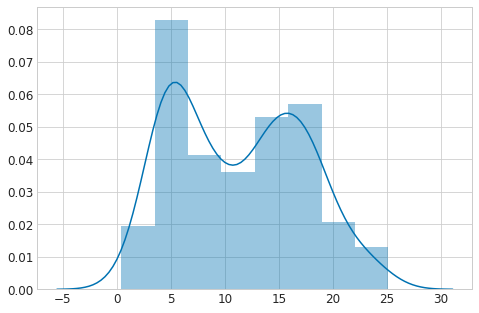

In [6]:
sns.distplot(sample)

混合正規分布の同時分布を潜在変数 $z_n$ について周辺化すると

$$
log(Y | \pi, \mu, \sigma) = \sum_n^N \log \left[ \sum_k^K \exp \left( \log \pi_k + \log \mathcal{N}(y_n | \mu_k, \sigma_k) \right) \right]
$$

In [7]:
model = """
data {
    int N;
    int K;
    vector[N] y;
}
parameters {
    simplex[K] pi;
    real mu[K];
    real<lower=0> sigma[K];
}
model {
    real logprob[K];
    for(n in 1:N) {
        for(k in 1:K) {
            logprob[k] = log(pi[k]) + normal_lpdf(y[n] | mu[k], sigma[k]);
        }
        target += log_sum_exp(logprob);
    }
}
"""

In [8]:
data = {
    "N": n,
    "K": 2,
    "y": sample
}

sm = stan_cache(model)

In [9]:
params = sm.sampling(data=data, iter=8000, warmup=2000)

In [10]:
params

Inference for Stan model: anon_model_ab1dea668a6f203232e910a66acb343f.
4 chains, each with iter=8000; warmup=2000; thin=1; 
post-warmup draws per chain=6000, total post-warmup draws=24000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1]       0.6     0.3   0.42 4.3e-4   0.09   0.75    1.0    1.0      2  18.15
pi[2]       0.4     0.3   0.42 1.7e-4 2.7e-3   0.25   0.91    1.0      2  18.15
mu[1]    2210.3  2102.9 7244.5  -5658   5.31   11.1  11.64  2.7e4     12   1.35
mu[2]    -386.3   358.4 983.55  -3115 -431.4  11.43  15.44 834.15      8   2.51
sigma[1]    inf     nan    inf   1.56    3.9   6.044.1e3041.6e308    nan    nan
sigma[2]    inf     nan    inf    3.7   5.413.9e3039.1e3071.7e308    nan    nan
lp__     -266.3  204.15 288.73 -768.5 -469.3 -100.0 -98.71 -97.54      2  187.7

Samples were drawn using NUTS at Sun Dec 23 01:56:53 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reducti

In [11]:
pd.DataFrame({
    'pi1': params['pi'][:, 0],
    'pi2': params['pi'][:, 1],
    'mu1': params['mu'][:, 0],
    'mu2': params['mu'][:, 1],
    'sigma1': params['sigma'][:, 0],
    'sigma2': params['sigma'][:, 1]
}).describe().T

,count,mean,std,min,25%,50%,75%,max
pi1,24000.0,0.596566,0.422929,2.689899e-06,0.133423,7.502711e-01,9.972721e-01,9.999999e-01
pi2,24000.0,0.403434,0.422929,1.494010e-07,0.002728,2.497289e-01,8.665765e-01,9.999973e-01
mu1,24000.0,2210.391618,7244.593624,-1.689386e+04,5.307728,1.110493e+01,1.164149e+01,4.133514e+04
mu2,24000.0,-386.334678,983.554973,-3.436512e+03,-431.423823,1.143048e+01,1.544410e+01,1.134032e+03
sigma1,24000.0,inf,inf,1.061352e+00,4.601483,6.035698e+00,1.874497e+304,1.797657e+308
sigma2,24000.0,inf,inf,2.912545e+00,5.408828,3.929300e+303,9.101507e+307,1.796832e+308


収束しないw